In [2]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from langdetect import detect
from logs.best_topic_names import topic_col, emotion_col, style_col
import matplotlib.dates as md
import plotly.express as px
import spacy
from pliers.extractors import PredefinedDictionaryExtractor, merge_results
from pliers.stimuli import ComplexTextStim
import textdescriptives as td

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Structure
Content and narratives
- Topic modeling of EU Commission tweets
- Which topics generate most engagement (likes, comments, retweets, quotes)? 
- Which topics generate most positive comments? 
- Which narratives resonate the most?

Styles
- How is the style of the European commission tweeting? How does it change over time?

Emotional content
- What is the prevalent emotional content? How does it change over time?

Comparison
- How do each of these predict engagement?
- Which are the best predictors of engagement?
    - Bag of words models
    - Topic models
    - Transformer-based models
    - Style-based
    - Sentiment-based

### Load data and extract additional features

In [77]:
df = pd.read_json(f'logs/topic/distilbert-base-uncased-finetuned-sst-2-english_vocab-500_bow-499_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus/topic_preds_1.jsonl',
                  orient='records', 
                  lines=True)
df.rename(dict(zip([f'topic_{i}' for i in range(20)], topic_col)), inplace=True, axis=1)
df['top_topic'] = df[topic_col].apply(lambda x: topic_col[x.argmax()], axis=1)
response_df = pd.read_json('processed/pre_topic_responses_sentiment.jsonl', 
                           orient='records', 
                           lines=True)   

#### Style descriptors

In [117]:
style_extracted = True

In [118]:
if style_extracted is False:
    nlp = spacy.load("en_core_web_md")
    nlp.add_pipe("textdescriptives")
    ext = PredefinedDictionaryExtractor(variables=['subtlexusfrequency'])
    target_cols = ['PredefinedDictionaryExtractor#subtlexusfrequency_Lg10WF',
                   'PredefinedDictionaryExtractor#subtlexusfrequency_SUBTLWF', 
                   'PredefinedDictionaryExtractor#subtlexusfrequency_Zipf-value']

    dfs = [] 
    for i, t in enumerate(df['text']):
        if i % 1000 == 0:
            print(i)
        try: 
            out = nlp(t)
            extracted = td.extract_df(out)
            for i, c in enumerate(list(out.doc._.pos_proportions.keys())):
                extracted[c] = list(out.doc._.pos_proportions.values())[i]
            for tc in target_cols:
                freq = merge_results(ext.transform(ComplexTextStim(text=t)))[tc].astype(float).mean()
                extracted[tc.split('#')[0]] = freq
            dfs.append(extracted) 
        except:
            dfs.append(pd.DataFrame([[np.nan]*len(extracted.columns)],
                                    columns=extracted.columns))
    df = pd.concat([df, pd.concat(dfs).reset_index(drop=True).drop('text',
                                                               axis=1)], axis=1)
    df.to_json('processed/post_topic_tweets_style.jsonl', orient='records', lines=True)
else:
    df = pd.read_json('processed/post_topic_tweets_style.jsonl', orient='records', lines=True)
    

In [119]:
df['n_mentions'] = df.text.str.replace(r'[^@]', '').str.len()
df['n_hashtags'] = df.text.str.replace(r'[^#]', '').str.len()

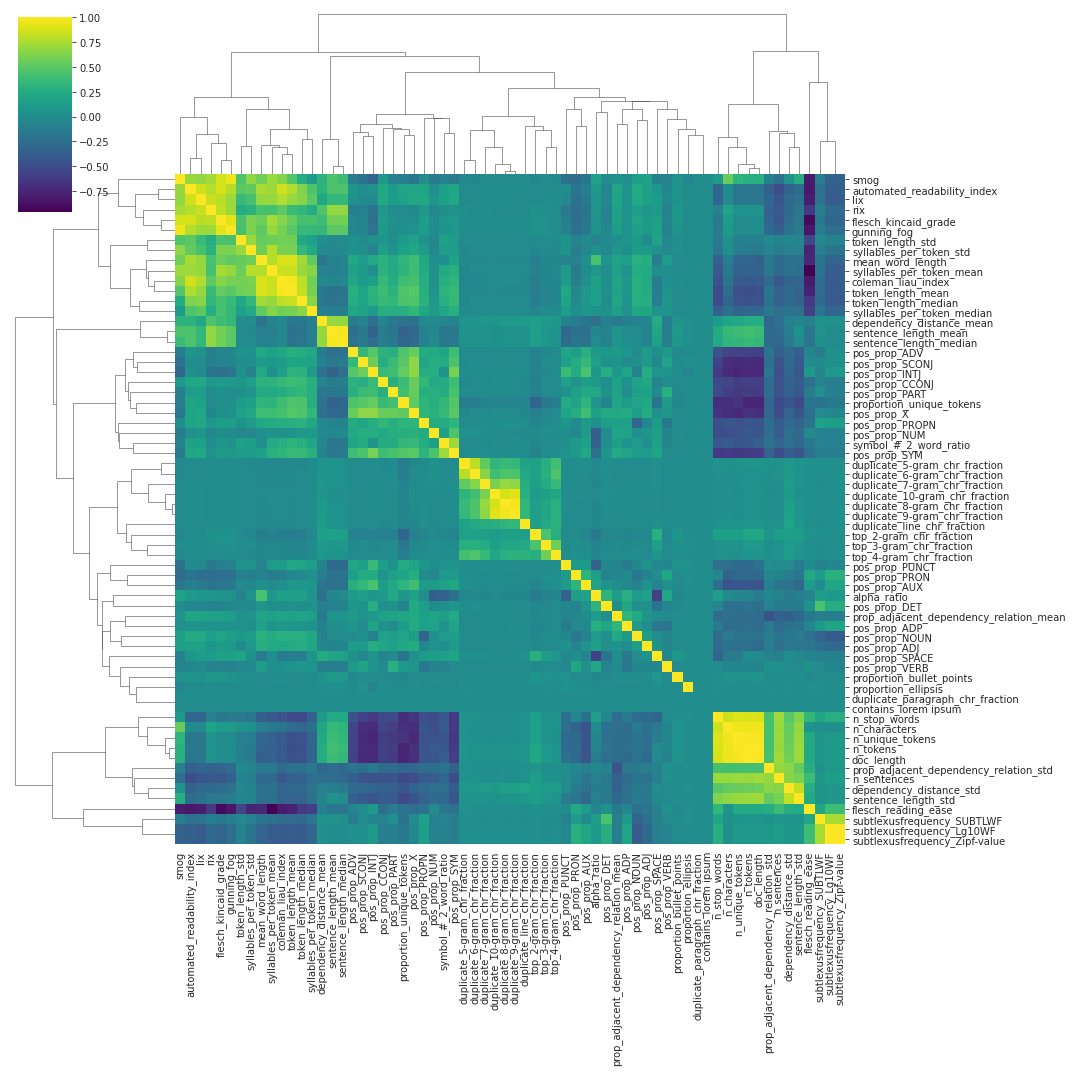

In [120]:
sns.clustermap(df[style_col].corr().fillna(0), 
               cmap='viridis', 
               figsize=(15,15), 
               xticklabels=True, 
               yticklabels=True)

#### Sentiment descriptors

In [121]:
from transformers import pipeline
classifier = pipeline("text-classification", 
                      model='cardiffnlp/twitter-roberta-base-sentiment',
                      return_all_scores=True, device=0,
                      function_to_apply='softmax')

In [122]:
def get_emo(lst):
    columns = [l['label'] for l in lst]
    vals = [l['score'] for l in lst]
    return pd.DataFrame([vals], columns=columns)

In [123]:
%%capture 
emos = pd.concat(df['text'].apply(lambda x: 
                                  get_emo(classifier(x)[0])).tolist())

In [124]:
df = pd.concat([df, emos.reset_index(drop=True)], axis=1)
df.rename({'LABEL_0': 'negative_sentiment', 
           'LABEL_1': 'neutral_sentiment',
           'LABEL_2': 'positive_sentiment'}, 
          axis=1,
          inplace=True)

In [3]:
#df['sum_count'] = df['like_count'] + df['quote_count'] + df['reply_count'] + df['retweet_count']
#df.to_json('processed/post_topic_tweets_style_and_sent.jsonl', orient='records', lines=True)
df = pd.read_json('processed/post_topic_tweets_style_and_sent.jsonl', orient='records', lines=True)

### Sentiment

In [30]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (27,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
colors = ['indianred', 'grey', sns.color_palette()[0]]


def plot_volume(freq='D', roll_window=7, outcomes=[]):
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
    grouped = df.groupby(grouper).mean().reset_index()
    for i,s in enumerate(outcomes):
        grouped[f'{s}_smoothed'] = grouped[s].rolling(roll_window,
                                                      min_periods=1).mean()
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=s, 
                     alpha=.2,
                     color=colors[i])
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=f'{s}_smoothed', 
                     label=s.replace('_',' ').capitalize(), 
                     color=colors[i])
    plt.ylabel(f'Score')
    plt.xlabel('')
    plt.title(f'Sentiment')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique():
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),.97), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator()) # (1,7)
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
    #plt.savefig(f'figures/sentiment_over_time.pdf')
    plt.show()

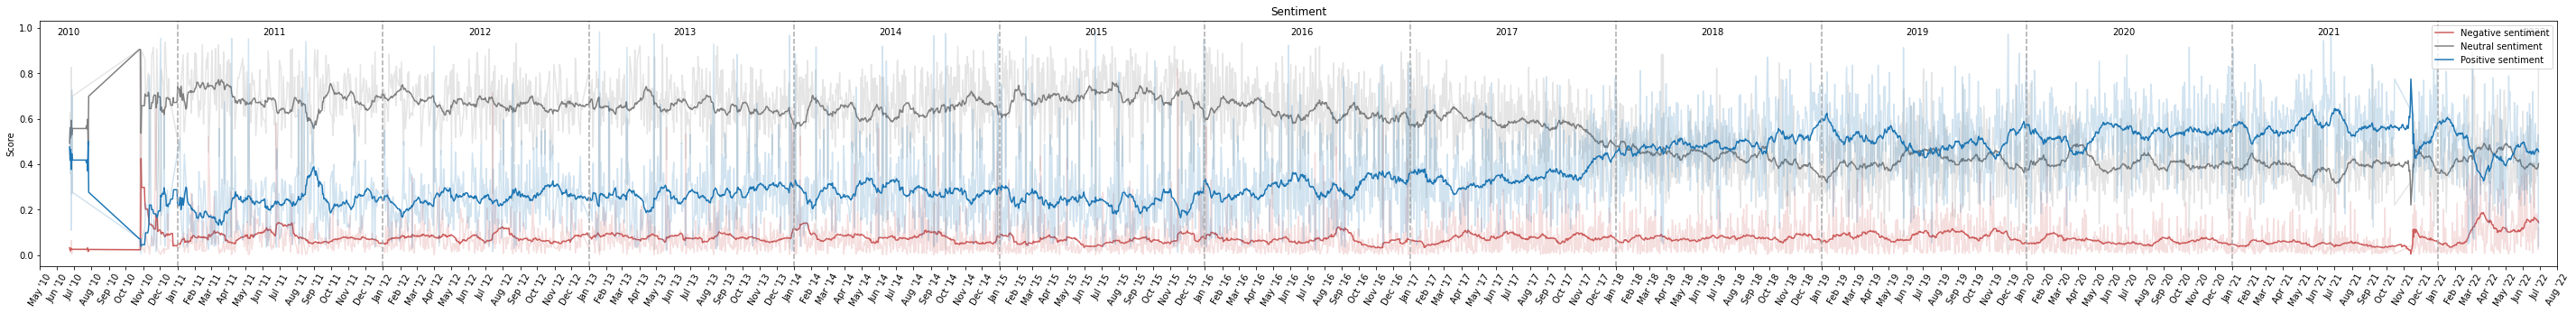

In [302]:
plot_volume(freq='D',roll_window=30, outcomes=['negative_sentiment', 
                                               'neutral_sentiment',
                                               'positive_sentiment'])

### Compare sentiment and style to other corpora

In [ ]:
fields = ['text', 'lang', 'id']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
df = _preprocessing(_read_tweets(fs, metrics, fields))

### Results of predictive models

In [105]:
dfs = []
for metric in ['like', 'retweet', 'quote', 'response', 'sum']:
    fs = glob.glob(f'logs/metrics/{metric}_count/pred*.pkl')
    for f in fs:
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

In [ ]:
for metric in ['like', 'retweet', 'quote', 'response', 'sum']:
    g = sns.lmplot(data=metrics[(metrics['split']=='test') & \
                                (metrics['metric']==metric)], 
                   x='prediction', y='label', 
                   hue='split',
                   col='model_name',
                   col_wrap=3)
    for a in g.axes:
        sns.lineplot(x=[1,500,1000], y=[1,500,1000], ax=a, 
                     color='darkred', linestyle='--')
    plt.show()

In [107]:
from sklearn.metrics import d2_tweedie_score, make_scorer
d2_tweedie_score_15 = make_scorer(d2_tweedie_score, power=1.2)

In [113]:
spears = metrics.groupby(['metric', 'split',
                 'model_name'])[['label', 'prediction']].apply(lambda x: d2_tweedie_score(y_pred=x['prediction'],
                                                                                          y_true=x['label'])).reset_index()
                                                               #x.corr('spearman').iloc[0,1]).reset_index()

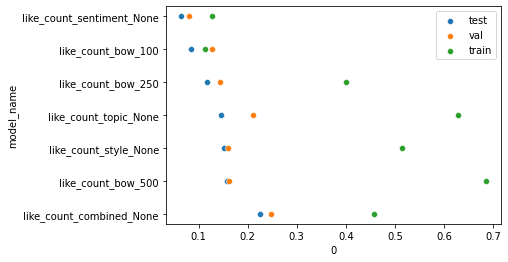

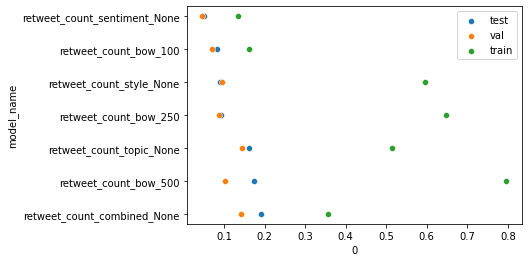

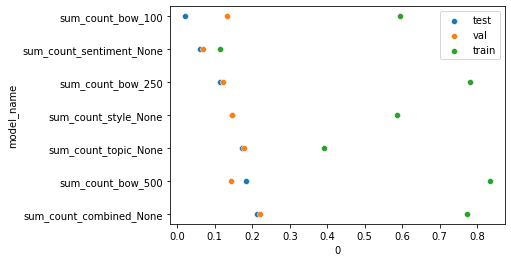

In [115]:
for metric in ['like', 'retweet', 'sum']:
    for out_metric in [0]:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x=0, label=split)
        plt.show()

### Predictive models

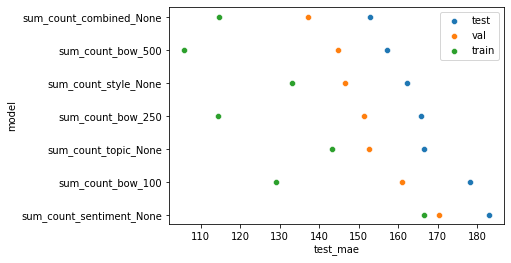

In [117]:
for metric in ['sum']:
    data = pd.DataFrame(json.load(open(f'logs/metrics/{metric}_count.json')))
    for out_metric in ['mae']:
        data = data.sort_values(by=f'test_{out_metric}', ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=data, y='model', x=f'{split}_{out_metric}', label=split)
        plt.show()

In [ ]:
import pickle as pkl
import xgboost
import shap

with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/metrics/{metric}_count/{metric}_count_*.pkl')
        for m in fnames:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            if 'topic' in m:
                feature_names = topic_col
            elif 'style' in m:
                feature_names = style_col
            elif 'combined' in m:
                feature_names = topic_col + emotion_col + style_col 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/metrics/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            plt.subplots(figsize=(20,5))
            sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            plt.xticks(rotation=90)
            plt.show()
            
            shaps = pkl.load(open(f'logs/metrics/{metric}_count/shap_{name}','rb'))
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))    
            shap.summary_plot(shaps, max_display=100, feature_names=feature_names)

    

In [101]:
for m in ['like', 'reply', 'retweet', 'quote', 'sum']:
    d = pd.read_csv(f'logs/metrics/{m}_count/grid.csv').sort_values(by='mean_test_score',
                                                                    ascending=False)

In [19]:
# TODO